# MLP
MLP, K=5, epochs=200.
Use mRNA.
Train set: filter none.
Valid set: filter middle.

In [25]:
from datetime import datetime
print(datetime.now())

2023-04-01 23:57:29.295015


In [26]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [27]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [28]:
RCI_FILE_TRAIN = 'train.pc_RCI.csv'
RCI_FILE_VALID = 'train.pc_RCI.csv'
RCI_FILE_TEST  = None # else 'test.pc_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_pc_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_pc_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_pc_transcripts.csv'

In [29]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [30]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [31]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [32]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-01 23:57:30.683287
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_88 (Dense)            (None, 64)                65664     
                                                                 
 dense_89 (Dense)            (None, 64)                4160      
                                                                 
 dense_90 (Dense)            (None, 64)                4160      
                                                                 
 dense_91 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [33]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
            self.discriminator = 0   # more balanced for mRNA
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [34]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        # lncRNA
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        # mRNA
        filename='pc.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-01 23:57:31.243170
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.pc_RCI.csv
Number of RCI values loaded 13669
Num RCI: 13669
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_pc_transcripts.csv
Loaded 13669 sequences.
2023-04-01 23:58:39.563187

Training # 1 1
2023-04-01 23:58:39.563396
2023-04-01 23:58:39.563450
Discriminator ZERO 0
Train 1:0 5722:5211 52.34%
Computed class weights: {0: 1.0490308961811552, 1: 0.95534778049633}
Valid 1:0 1417:1319 51.79%
FIT
2023-04-01 23:58:39.711965


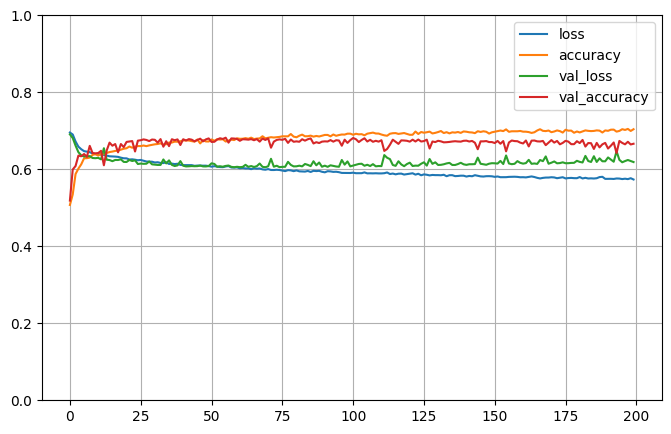


2023-04-02 00:03:02.930873

Testing # 1 1
2023-04-02 00:03:02.930988
2023-04-02 00:03:02.931039
PREDICT
2023-04-02 00:03:02.960962
Test 1:0 1417:1319 51.79%
Predict 1:0 1486:1250 54.31%
Test sizes (2736, 1025) (2736,)
Range of scores: 0.018151129 to 0.9702361
Score threshold 0.5
Confusion matrix
 [[828 491]
 [422 995]]
Normalized matrix
 [[0.30263158 0.17945906]
 [0.15423977 0.36366959]]


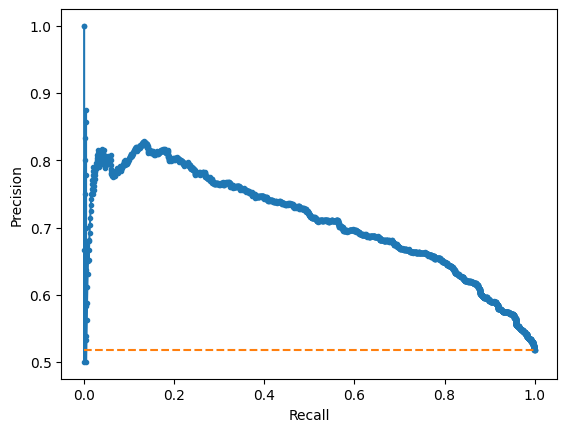

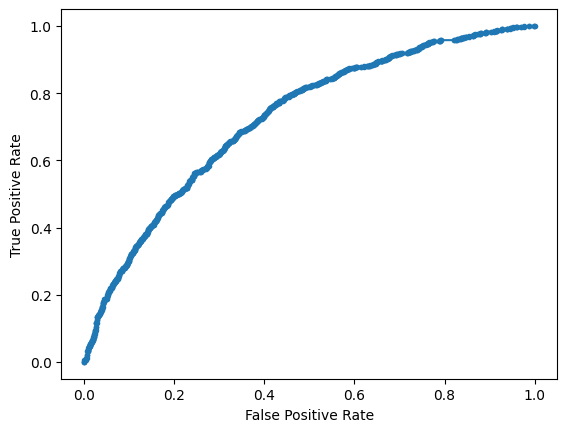

Accuracy: 66.63% Precision: 66.96% Recall: 70.22%
F1: 68.55% MCC: 0.3310
AUPRC: 71.00% AUROC: 72.37%
 accuracy [66.63011695906432]
 precision [66.95827725437415]
 recall [70.21877205363444]
 F1 [68.54977609369618]
 MCC [0.33095781139243424]
 AUPRC [70.99741799106528]
 AUROC [72.37257112405786]
2023-04-02 00:03:03.857054

Training # 1 2
2023-04-02 00:03:03.859282
2023-04-02 00:03:03.859346
Discriminator ZERO 0
Train 1:0 5688:5244 52.03%
Computed class weights: {0: 1.0423340961098397, 1: 0.9609704641350211}
Valid 1:0 1451:1286 53.01%
FIT
2023-04-02 00:03:04.006871


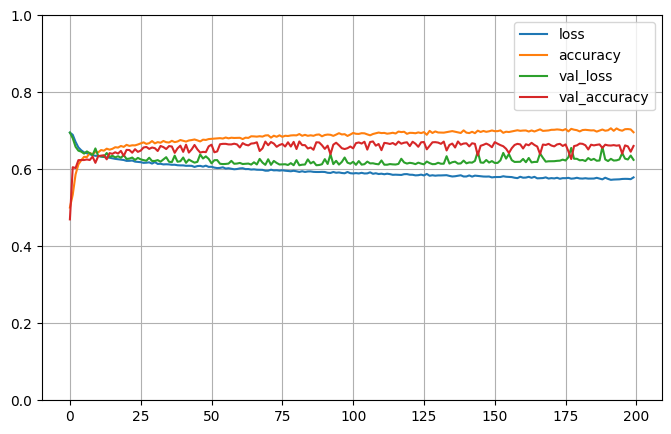


2023-04-02 00:07:27.221907

Testing # 1 2
2023-04-02 00:07:27.222036
2023-04-02 00:07:27.222094
PREDICT
2023-04-02 00:07:27.249739
Test 1:0 1451:1286 53.01%
Predict 1:0 1386:1351 50.64%
Test sizes (2737, 1025) (2737,)
Range of scores: 0.041227736 to 0.9672958
Score threshold 0.5
Confusion matrix
 [[854 432]
 [497 954]]
Normalized matrix
 [[0.31202046 0.15783705]
 [0.18158568 0.34855681]]


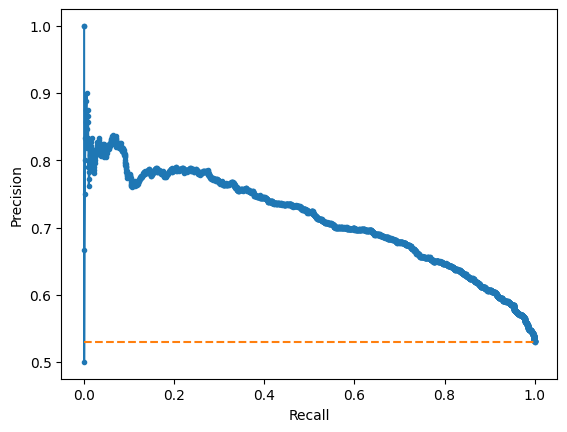

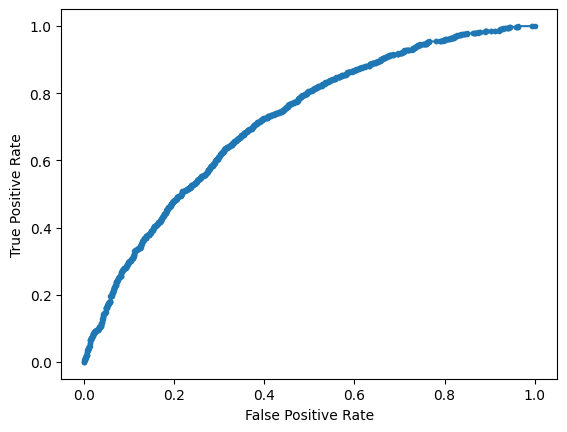

Accuracy: 66.06% Precision: 68.83% Recall: 65.75%
F1: 67.25% MCC: 0.3210
AUPRC: 71.28% AUROC: 71.67%
 accuracy [66.0577274388016]
 precision [68.83116883116884]
 recall [65.74776016540316]
 F1 [67.2541416989778]
 MCC [0.3209936610041878]
 AUPRC [71.28128490361922]
 AUROC [71.67036622997172]
2023-04-02 00:07:28.129646

Training # 1 3
2023-04-02 00:07:28.131188
2023-04-02 00:07:28.131455
Discriminator ZERO 0
Train 1:0 5711:5234 52.18%
Computed class weights: {0: 1.0455674436377531, 1: 0.9582384871300998}
Valid 1:0 1428:1296 52.42%
FIT
2023-04-02 00:07:28.276348


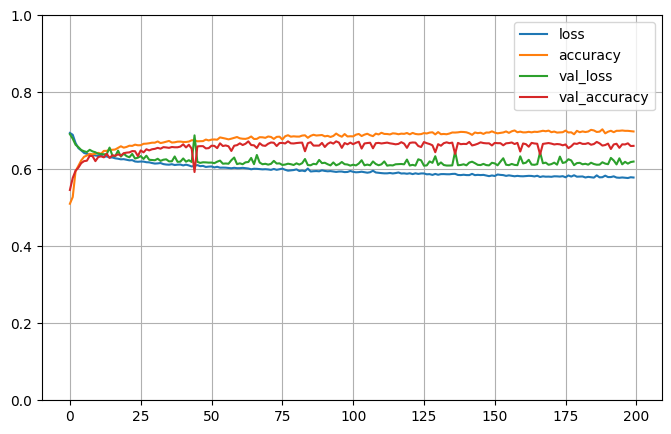


2023-04-02 00:11:51.670889

Testing # 1 3
2023-04-02 00:11:51.672849
2023-04-02 00:11:51.673311
PREDICT
2023-04-02 00:11:51.712690
Test 1:0 1428:1296 52.42%
Predict 1:0 1280:1444 46.99%
Test sizes (2724, 1025) (2724,)
Range of scores: 0.029930009 to 0.9728775
Score threshold 0.5
Confusion matrix
 [[908 388]
 [536 892]]
Normalized matrix
 [[0.33333333 0.14243759]
 [0.19676946 0.32745962]]


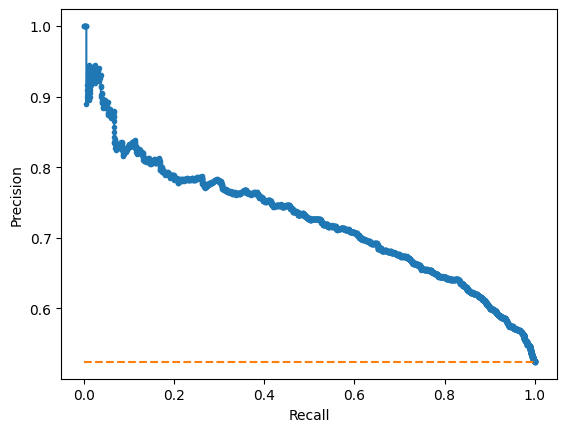

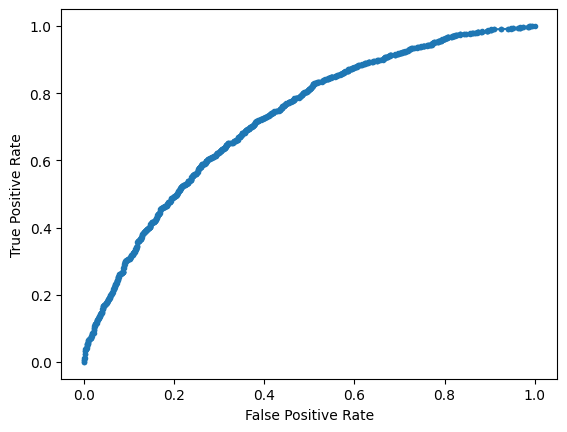

Accuracy: 66.08% Precision: 69.69% Recall: 62.46%
F1: 65.88% MCC: 0.3255
AUPRC: 72.47% AUROC: 72.45%
 accuracy [66.07929515418502]
 precision [69.6875]
 recall [62.46498599439776]
 F1 [65.87887740029542]
 MCC [0.3254754373871142]
 AUPRC [72.46874992038906]
 AUROC [72.45159637929245]
2023-04-02 00:11:52.789420

Training # 1 4
2023-04-02 00:11:52.791540
2023-04-02 00:11:52.791942
Discriminator ZERO 0
Train 1:0 5701:5226 52.17%
Computed class weights: {0: 1.0454458476846538, 1: 0.9583406419926329}
Valid 1:0 1438:1304 52.44%
FIT
2023-04-02 00:11:52.992825


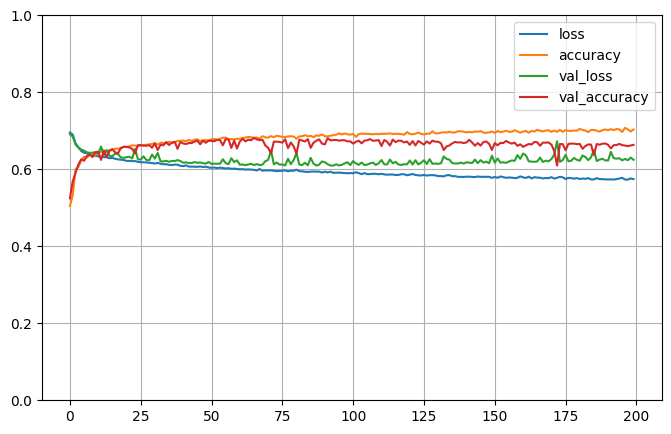


2023-04-02 00:16:03.467162

Testing # 1 4
2023-04-02 00:16:03.467285
2023-04-02 00:16:03.467331
PREDICT
2023-04-02 00:16:03.492719
Test 1:0 1438:1304 52.44%
Predict 1:0 1645:1097 59.99%
Test sizes (2742, 1025) (2742,)
Range of scores: 0.030071417 to 0.9748706
Score threshold 0.5
Confusion matrix
 [[ 739  565]
 [ 358 1080]]
Normalized matrix
 [[0.26951131 0.20605398]
 [0.13056163 0.39387309]]


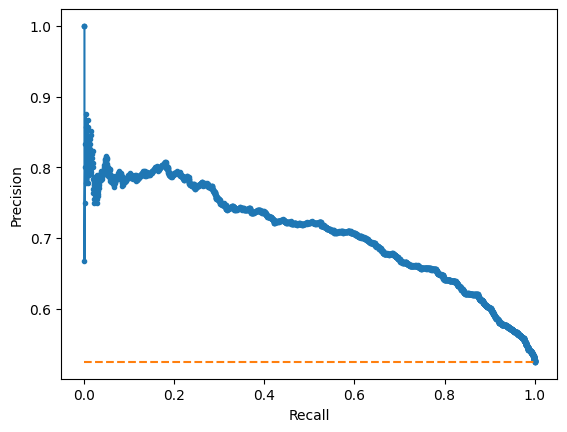

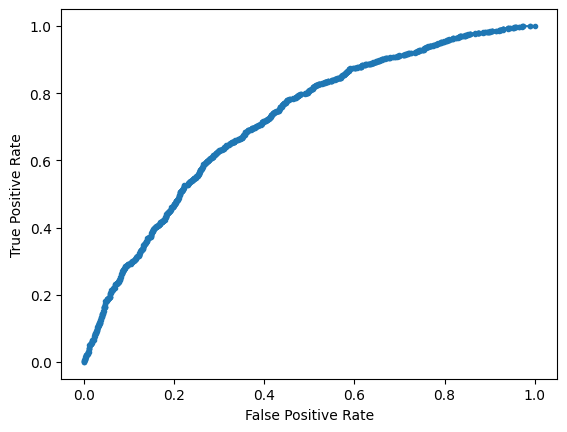

Accuracy: 66.34% Precision: 65.65% Recall: 75.10%
F1: 70.06% MCC: 0.3239
AUPRC: 70.78% AUROC: 71.68%
 accuracy [66.3384390955507]
 precision [65.65349544072949]
 recall [75.10431154381085]
 F1 [70.06162828413883]
 MCC [0.3239160293015607]
 AUPRC [70.78221205901426]
 AUROC [71.67637610177734]
2023-04-02 00:16:04.421816

Training # 1 5
2023-04-02 00:16:04.422294
2023-04-02 00:16:04.422356
Discriminator ZERO 0
Train 1:0 5734:5205 52.42%
Computed class weights: {0: 1.0508165225744477, 1: 0.9538716428322288}
Valid 1:0 1405:1325 51.47%
FIT
2023-04-02 00:16:04.564301


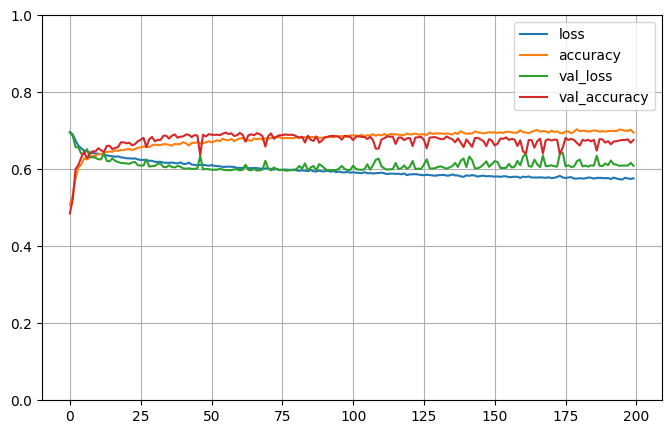


2023-04-02 00:20:27.883580

Testing # 1 5
2023-04-02 00:20:27.883704
2023-04-02 00:20:27.883750
PREDICT
2023-04-02 00:20:27.915213
Test 1:0 1405:1325 51.47%
Predict 1:0 1539:1191 56.37%
Test sizes (2730, 1025) (2730,)
Range of scores: 0.02254141 to 0.9648114
Score threshold 0.5
Confusion matrix
 [[ 816  509]
 [ 375 1030]]
Normalized matrix
 [[0.2989011  0.18644689]
 [0.13736264 0.37728938]]


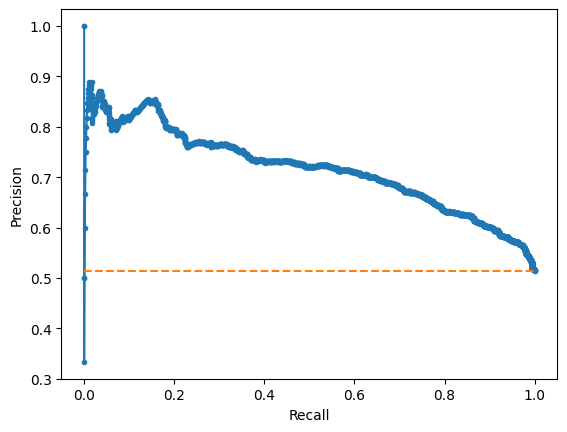

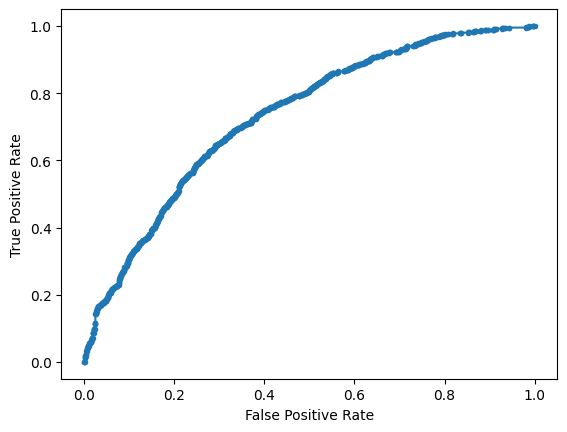

Accuracy: 67.62% Precision: 66.93% Recall: 73.31%
F1: 69.97% MCC: 0.3517
AUPRC: 71.65% AUROC: 73.14%
 accuracy [67.61904761904762]
 precision [66.92657569850552]
 recall [73.30960854092527]
 F1 [69.97282608695652]
 MCC [0.35166412584662926]
 AUPRC [71.64648514762075]
 AUROC [73.14281877392064]
2023-04-02 00:20:28.674726

Training # 2 1
2023-04-02 00:20:28.676535
2023-04-02 00:20:28.676606
Discriminator ZERO 0
Train 1:0 5710:5221 52.24%
Computed class weights: {0: 1.0468301091744876, 1: 0.9571803852889668}
Valid 1:0 1429:1309 52.19%
FIT
2023-04-02 00:20:28.824676


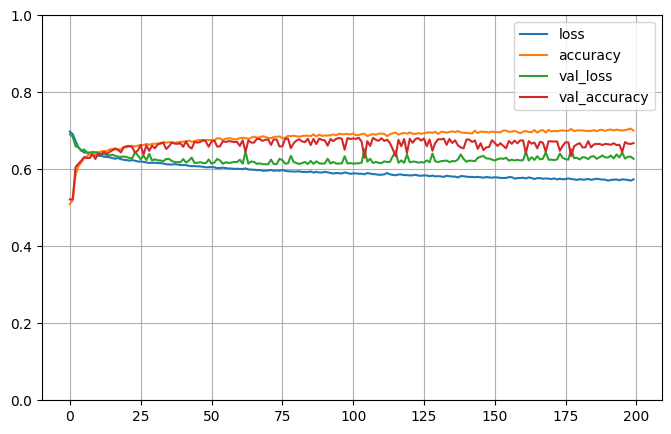


2023-04-02 00:25:52.039648

Testing # 2 1
2023-04-02 00:25:52.041572
2023-04-02 00:25:52.042017
PREDICT
2023-04-02 00:25:52.065150
Test 1:0 1429:1309 52.19%
Predict 1:0 1560:1178 56.98%
Test sizes (2738, 1025) (2738,)
Range of scores: 0.023261152 to 0.94629806
Score threshold 0.5
Confusion matrix
 [[ 789  520]
 [ 389 1040]]
Normalized matrix
 [[0.28816654 0.18991965]
 [0.14207451 0.3798393 ]]


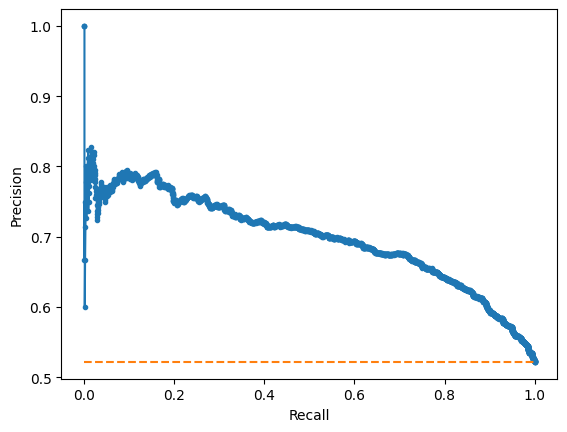

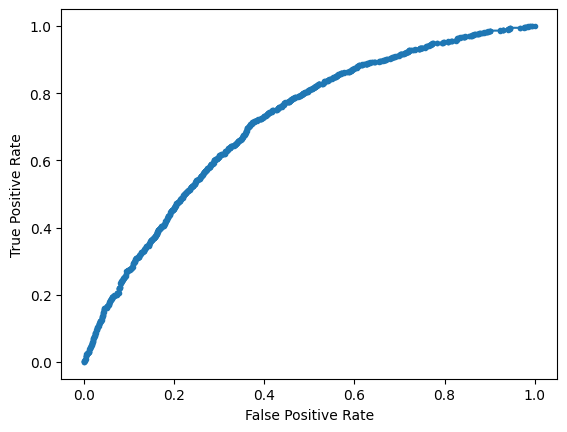

Accuracy: 66.80% Precision: 66.67% Recall: 72.78%
F1: 69.59% MCC: 0.3335
AUPRC: 69.78% AUROC: 71.27%
 accuracy [66.80058436815195]
 precision [66.66666666666666]
 recall [72.778166550035]
 F1 [69.58849113415859]
 MCC [0.33347579469649674]
 AUPRC [69.78382893076869]
 AUROC [71.26728291672926]
2023-04-02 00:25:52.816182

Training # 2 2
2023-04-02 00:25:52.817952
2023-04-02 00:25:52.818021
Discriminator ZERO 0
Train 1:0 5724:5220 52.30%
Computed class weights: {0: 1.0482758620689656, 1: 0.9559748427672956}
Valid 1:0 1415:1310 51.93%
FIT
2023-04-02 00:25:52.960883


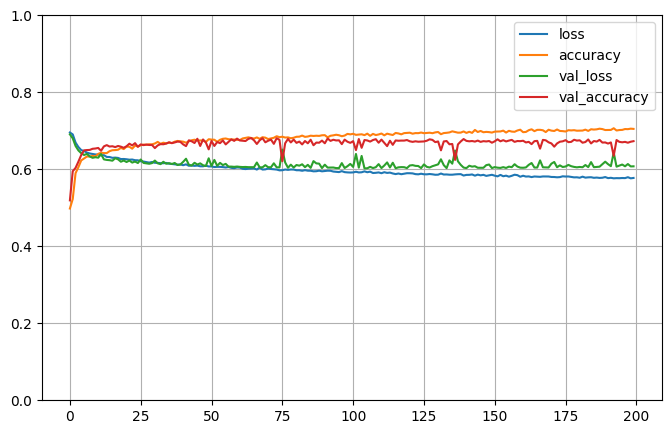


2023-04-02 00:30:16.501328

Testing # 2 2
2023-04-02 00:30:16.502970
2023-04-02 00:30:16.503025
PREDICT
2023-04-02 00:30:16.535365
Test 1:0 1415:1310 51.93%
Predict 1:0 1578:1147 57.91%
Test sizes (2725, 1025) (2725,)
Range of scores: 0.037731614 to 0.97645164
Score threshold 0.5
Confusion matrix
 [[ 783  527]
 [ 364 1051]]
Normalized matrix
 [[0.28733945 0.1933945 ]
 [0.13357798 0.38568807]]


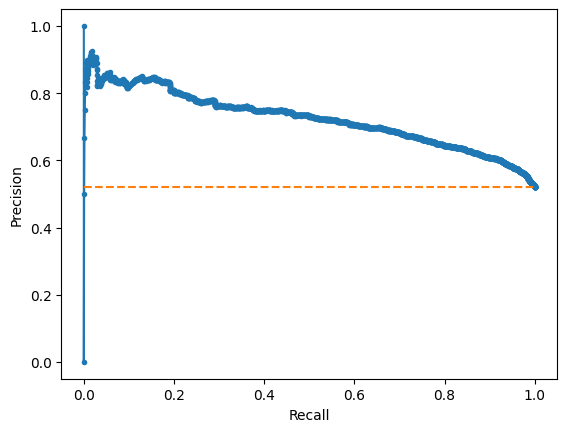

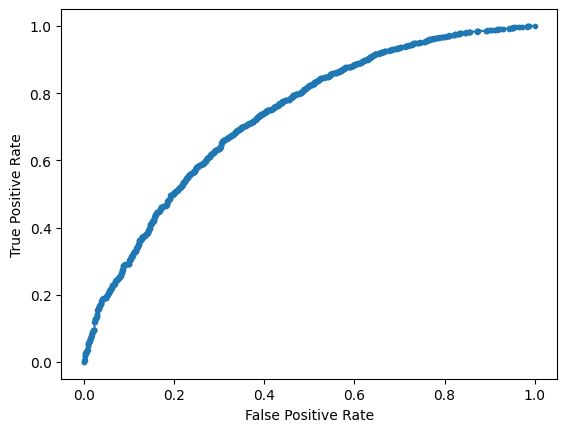

Accuracy: 67.30% Precision: 66.60% Recall: 74.28%
F1: 70.23% MCC: 0.3446
AUPRC: 72.42% AUROC: 73.33%
 accuracy [67.30275229357798]
 precision [66.60329531051966]
 recall [74.2756183745583]
 F1 [70.23053792181757]
 MCC [0.34455023050082245]
 AUPRC [72.41693717261147]
 AUROC [73.33466404121599]
2023-04-02 00:30:17.508413

Training # 2 3
2023-04-02 00:30:17.509271
2023-04-02 00:30:17.509335
Discriminator ZERO 0
Train 1:0 5720:5217 52.30%
Computed class weights: {0: 1.0482077822503355, 1: 0.9560314685314686}
Valid 1:0 1419:1313 51.94%
FIT
2023-04-02 00:30:17.648020


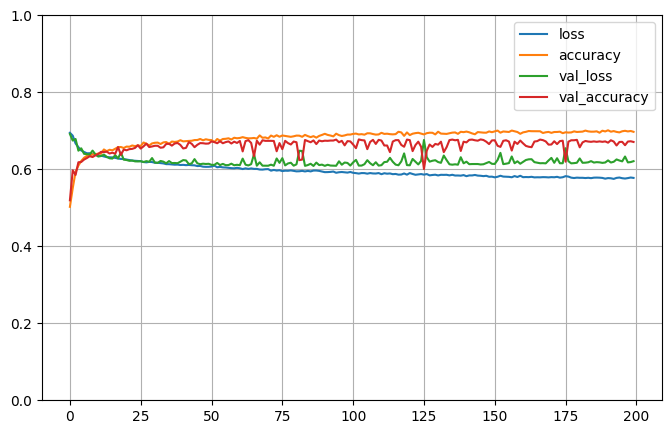


2023-04-02 00:35:41.065451

Testing # 2 3
2023-04-02 00:35:41.070588
2023-04-02 00:35:41.071160
PREDICT
2023-04-02 00:35:41.110707
Test 1:0 1419:1313 51.94%
Predict 1:0 1678:1054 61.42%
Test sizes (2732, 1025) (2732,)
Range of scores: 0.040101323 to 0.9670779
Score threshold 0.5
Confusion matrix
 [[ 734  579]
 [ 320 1099]]
Normalized matrix
 [[0.26866764 0.21193265]
 [0.11713031 0.4022694 ]]


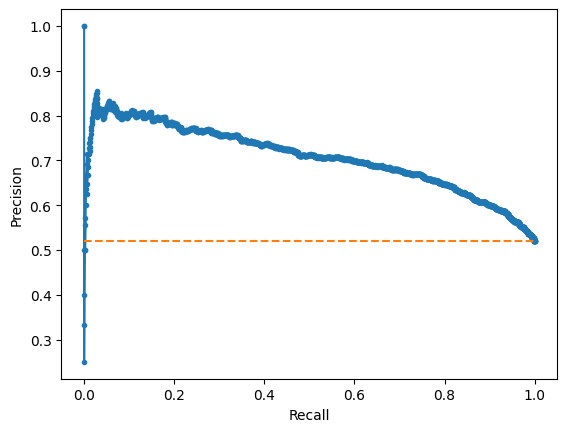

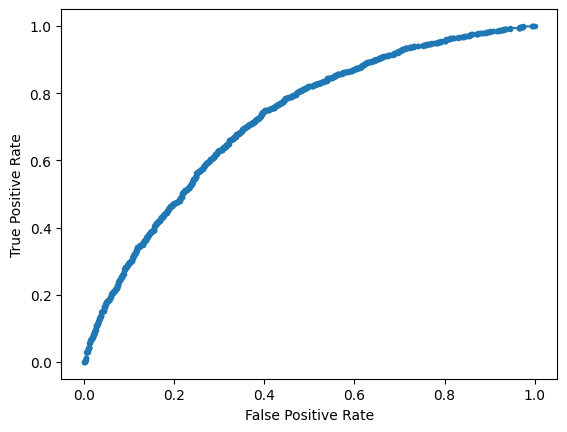

Accuracy: 67.09% Precision: 65.49% Recall: 77.45%
F1: 70.97% MCC: 0.3423
AUPRC: 70.67% AUROC: 72.22%
 accuracy [67.09370424597365]
 precision [65.49463647199046]
 recall [77.44890768146581]
 F1 [70.97190829835324]
 MCC [0.3423116026489311]
 AUPRC [70.67430294670771]
 AUROC [72.21990535368384]
2023-04-02 00:35:42.104155

Training # 2 4
2023-04-02 00:35:42.105309
2023-04-02 00:35:42.105376
Discriminator ZERO 0
Train 1:0 5672:5261 51.88%
Computed class weights: {0: 1.0390610150161566, 1: 0.9637693935119888}
Valid 1:0 1467:1269 53.62%
FIT
2023-04-02 00:35:42.241481


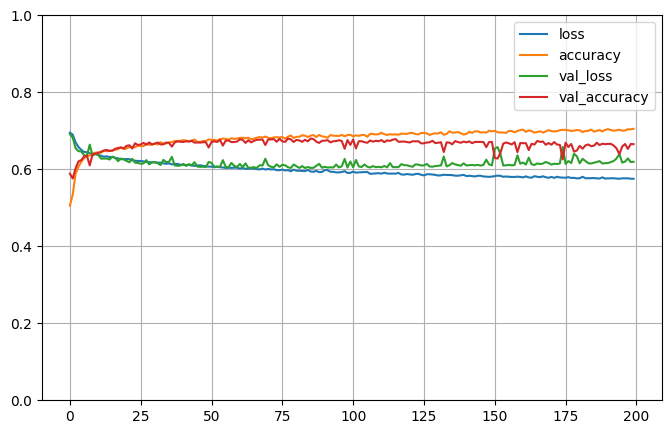


2023-04-02 00:40:05.576327

Testing # 2 4
2023-04-02 00:40:05.578022
2023-04-02 00:40:05.578443
PREDICT
2023-04-02 00:40:05.606550
Test 1:0 1467:1269 53.62%
Predict 1:0 1445:1291 52.81%
Test sizes (2736, 1025) (2736,)
Range of scores: 0.034630198 to 0.97621363
Score threshold 0.5
Confusion matrix
 [[822 447]
 [469 998]]
Normalized matrix
 [[0.3004386  0.16337719]
 [0.17141813 0.36476608]]


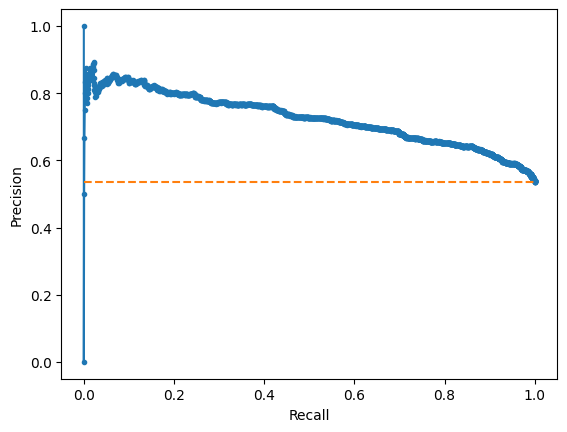

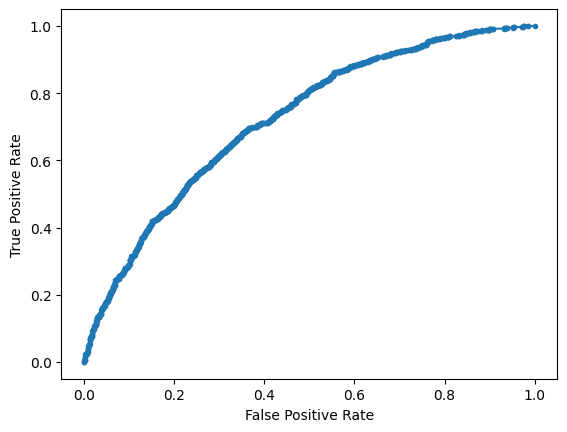

Accuracy: 66.52% Precision: 69.07% Recall: 68.03%
F1: 68.54% MCC: 0.3277
AUPRC: 72.47% AUROC: 72.11%
 accuracy [66.52046783625731]
 precision [69.06574394463668]
 recall [68.02999318336742]
 F1 [68.54395604395604]
 MCC [0.3277134394768591]
 AUPRC [72.47079016508458]
 AUROC [72.1095248608338]
2023-04-02 00:40:06.850605

Training # 2 5
2023-04-02 00:40:06.852763
2023-04-02 00:40:06.853202
Discriminator ZERO 0
Train 1:0 5730:5201 52.42%
Computed class weights: {0: 1.0508556046914055, 1: 0.9538394415357766}
Valid 1:0 1409:1329 51.46%
FIT
2023-04-02 00:40:07.064288


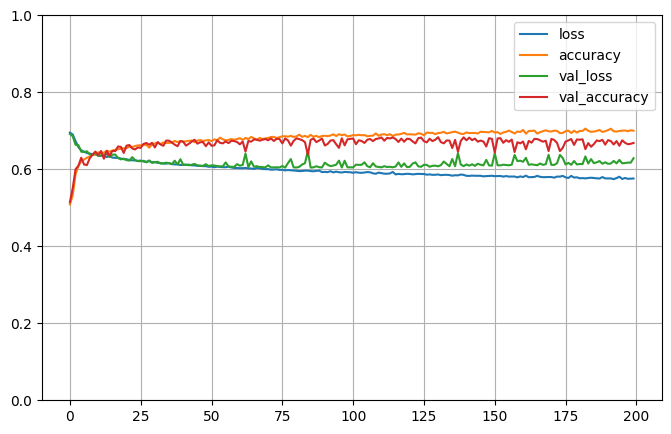


2023-04-02 00:44:19.411000

Testing # 2 5
2023-04-02 00:44:19.411125
2023-04-02 00:44:19.411176
PREDICT
2023-04-02 00:44:19.436035
Test 1:0 1409:1329 51.46%
Predict 1:0 1759:979 64.24%
Test sizes (2738, 1025) (2738,)
Range of scores: 0.023082241 to 0.9882203
Score threshold 0.5
Confusion matrix
 [[ 700  629]
 [ 279 1130]]
Normalized matrix
 [[0.25566107 0.22972973]
 [0.1018992  0.41271001]]


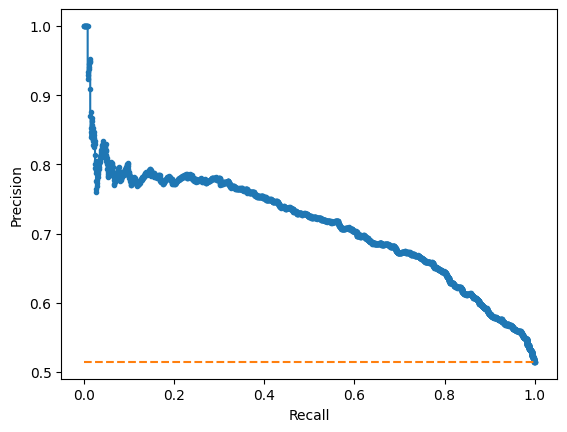

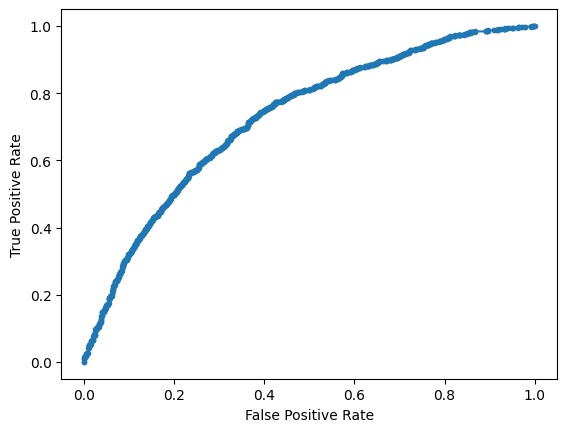

Accuracy: 66.84% Precision: 64.24% Recall: 80.20%
F1: 71.34% MCC: 0.3428
AUPRC: 71.26% AUROC: 72.66%
 accuracy [66.83710737764792]
 precision [64.24104604889142]
 recall [80.19872249822569]
 F1 [71.33838383838383]
 MCC [0.342761594865747]
 AUPRC [71.25849605088088]
 AUROC [72.66225239124387]
2023-04-02 00:44:20.264526


In [35]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [36]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 66.73% std 0.51
 precision mean 67.01% std 1.73
 recall mean 71.96% std 5.41
 F1 mean 69.24% std 1.70
 MCC mean 0.33% std 0.01
 AUPRC mean 71.38% std 0.89
 AUROC mean 72.29% std 0.65
 accuracy [[66.63011695906432], [66.0577274388016], [66.07929515418502], [66.3384390955507], [67.61904761904762], [66.80058436815195], [67.30275229357798], [67.09370424597365], [66.52046783625731], [66.83710737764792]]
 precision [[66.95827725437415], [68.83116883116884], [69.6875], [65.65349544072949], [66.92657569850552], [66.66666666666666], [66.60329531051966], [65.49463647199046], [69.06574394463668], [64.24104604889142]]
 recall [[70.21877205363444], [65.74776016540316], [62.46498599439776], [75.10431154381085], [73.30960854092527], [72.778166550035], [74.2756183745583], [77.44890768146581], [68.02999318336742], [80.19872249822569]]
 F1 [[68.54977609369618], [67.2541416989778], [65.87887740029542], [70.06162828413883], [69.97282608695652], [69.58849113415859], [70.23053792181757], [70.